## Imports

In [ ]:
import json

import kagglehub

import tensorflow as tf
import keras
from keras import Sequential, Input
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

import random

import seaborn as sns

from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix


# Set random state for reproducibility
random_state = 23
random.seed(random_state)
np.random.seed(random_state)
tf.random.set_seed(random_state)

2026-01-14 10:19:01.865455: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768385942.051042      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768385942.102462      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768385942.547034      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768385942.547070      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768385942.547073      24 computation_placer.cc:177] computation placer alr

In [ ]:
# Set base path for datasets and common info
# IF YOU ARE NOT USING KAGGLE
BASE_PATH = kagglehub.dataset_download("mattiaingrassia/gtzan-2-0")+"/"
# IF YOU ARE USING KAGGLE, ADD THE DATASET TO THE NOTEBOOOK, COMMENT THE PREVIOUS LINE AND UNCOMMENT THE FOLLOWING ONE
# BASE_PATH = "/kaggle/input/gtzan-2-0/"

GENRES = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
NUM_CLASSES = len(GENRES)

In [ ]:
# Plot functions
sns.set_style("darkgrid")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 11

train_color = "#2E86AB"  # Deep blue
val_color = "#A23B72"    # Deep magenta

color_palette = ["#a6cee3", "#1f78b4","#b2df8a", "#e31a1c"]
model_versions = ["2.0", "3.1", "3.2", "3.3"]
model_color_map = dict(zip(model_versions, color_palette))

def plot_loss(history):
    loss = history.history.get("loss")
    val_loss = history.history.get("val_loss")
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(8, 6))

    plt.plot(epochs, loss, linewidth=2.5, label="Training Loss", color=train_color, marker='o', markersize=4, alpha=0.8)
    plt.plot(epochs, val_loss, linewidth=2.5, label="Validation Loss", color=val_color, marker='s', markersize=4, alpha=0.8)

    plt.title("Model Loss Over Training", fontsize=14, fontweight='bold', pad=15)
    plt.xlabel("Epoch", fontsize=12, fontweight='semibold')
    plt.ylabel("Loss", fontsize=12, fontweight='semibold')
    plt.legend(loc='upper right', frameon=True, shadow=True, fontsize=11)
    plt.grid(True, alpha=0.5, linestyle='--')

    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()

def plot_accuracy(history):
    acc = history.history.get("accuracy")
    val_acc = history.history.get("val_accuracy")
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, acc, linewidth=2.5, label="Training Accuracy", color=train_color, marker='o', markersize=4, alpha=0.8)
    plt.plot(epochs, val_acc, linewidth=2.5, label="Validation Accuracy", color=val_color, marker='s', markersize=4, alpha=0.8)

    plt.title("Model Accuracy Over Training", fontsize=14, fontweight='bold', pad=15)
    plt.xlabel("Epoch", fontsize=12, fontweight='semibold')
    plt.ylabel("Accuracy", fontsize=12, fontweight='semibold')
    plt.ylim(0, 1.01)
    plt.legend(loc='lower right', frameon=True, shadow=True, fontsize=11)
    plt.grid(True, alpha=0.5, linestyle='--')

    ax = plt.gca()
    ax.set_yticks(np.arange(0.1, 1.01, 0.1))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_test, y_pred, model_version):
    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 6))
    sns.heatmap(
        cm,
        xticklabels=GENRES,
        yticklabels=GENRES,
        cmap="mako",
        annot=True,
        fmt="d"
    )
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - Model {model_version}")
    plt.tight_layout()
    plt.show()

def plot_classwise_metrics(classification_dict, model_version, color):
    classes = [str(i) for i in range(NUM_CLASSES)]
    
    precision = [classification_dict[c]["precision"] for c in classes]
    recall = [classification_dict[c]["recall"] for c in classes]
    f1 = [classification_dict[c]["f1-score"] for c in classes]

    x = np.arange(NUM_CLASSES)

    metrics = {
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1
    }

    for metric_name, values in metrics.items():
        plt.figure(figsize=(12, 6))
        plt.bar(x, values, color=color, edgecolor="#222222")
        plt.xticks(x, GENRES, rotation=90)
        plt.ylim(0, 1.01)
        ax = plt.gca()
        ax.set_yticks(np.arange(0.1, 1.0, 0.1))
        plt.xlabel("Class")
        plt.ylabel(metric_name)
        plt.title(f"Class-wise {metric_name} - Model {model_version}")
        plt.grid(axis="y", linestyle="--", alpha=0.6)
        plt.tight_layout()
        plt.show()

def plot_overall_metrics(model_metrics, model_version):
    metric_names = ["accuracy", "precision", "recall", "f1-score"]
    values = [model_metrics[m] for m in metric_names]
    plt.figure(figsize=(8, 6))
    plt.bar(metric_names, values, color=model_color_map[model_version], edgecolor="#222222")
    plt.ylim(0, 1.01)
    ax = plt.gca()
    ax.set_yticks(np.arange(0.1, 1.0, 0.1))
    plt.ylabel("Score")
    plt.title(f"Overall Performance Metrics - Model {model_version}")
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

# Model evaluation
def create_report(y_true, preds, model_version):
    y_true_int = np.argmax(y_true, axis = 1)
    preds_int = np.argmax(preds, axis = 1)
    report = classification_report(y_true_int, preds_int, output_dict = True)
    plot_classwise_metrics(report, model_version, model_color_map[model_version])
    return report['accuracy'], report['macro avg']['precision'], report['macro avg']['recall'], report['macro avg']['f1-score']

def evaluate_ensemble(y_test, ensemble_preds, model_version, performances):
    
    # Plot the confusion matrix
    plot_confusion_matrix(np.argmax(y_test, axis = 1), np.argmax(ensemble_preds, axis = 1), model_version)

    # Create the report and plot classwise metrics
    accuracy, precision, recall, f1_score = create_report(y_test, ensemble_preds, model_version)
    performances[model_version] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1-score': f1_score 
    }

    # Plot the model metrics
    plot_overall_metrics(performances[model_version], model_version)
    return performances

def plot_metrics_comparison(performances):
    metrics = ["accuracy", "precision", "recall", "f1-score"]
    model_names = list(performances.keys())
    num_models = len(model_names)
    num_metrics = len(metrics)

    # X positions for metrics
    x = np.arange(num_metrics)
    bar_width = 0.8 / num_models  # keep bars compact

    plt.figure(figsize=(12, 6))

    for i, model_name in enumerate(model_names):
        values = [performances[model_name][m] for m in metrics]
        plt.bar(
            x + i * bar_width,
            values,
            width=bar_width,
            label= "Model - " + model_name,
            edgecolor="#222222",
            color=model_color_map[model_name[-3:]]
        )

    plt.xticks(
        x + bar_width * (num_models - 1) / 2,
        [m.capitalize() for m in metrics]
    )
    plt.ylim(0, 1)
    plt.ylabel("Score")
    plt.title("Ensemble Performance Comparison by Metric")
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

## Model 2.0 
Model 1.4 CNN For Feature Extraction + Hand-Crafted Features

In [4]:
# Read the csv dataset
df = pd.read_csv(BASE_PATH + "features_30_sec.csv")

# Remove the row corresponding to the missing image
df = df[df["filename"] != "jazz.00054.wav"]
df = df.drop(columns=["length"])

# Create X and y arrays for CNN
y_HCNN = df["label"].to_list()
X_HCNN = df.drop(columns=["label", "filename"])
X_HCNN = X_HCNN.to_numpy()

# Get the number of CSV features
CSV_FEATURES_NUMBER = len(X_HCNN[0])

In [5]:
# Load the CNN model
CNN_model = keras.models.load_model(BASE_PATH + 'CNN.keras')

# Select the cut point
last_layer = CNN_model.get_layer(name = "dense_9")

# Create the new model for feature extraction
FEATURE_EXTRACTOR = keras.Model(inputs = CNN_model.layers[0].input, outputs = last_layer.output)
FEATURE_EXTRACTOR.summary() 

# Get the number of convolutional features
CONV_FEATURES_NUMBER = last_layer.output.shape[1]

I0000 00:00:1768385953.462164      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 288, 432, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 283, 427, 64)   │         9,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 47, 71, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 44, 68, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 11, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 8, 14, 256)     │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 2, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │       196,736 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 861,760 (3.29 MB)

 Trainable params: 861,760 (3.29 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
def get_X_y_HCNN(indices_path, X_HCNN, y_HCNN):
    
    # Read indices
    with open(indices_path, "r") as file:
        indices = json.load(file)

    # Allocate needed memory
    X_ret = np.zeros((len(indices), CSV_FEATURES_NUMBER + CONV_FEATURES_NUMBER))
    y_ret = np.zeros(len(indices))

    i = 0
    for index, path in indices:
        
        # Read the image corresponding to the current index
        path = BASE_PATH + path[1:]
        img = mpimg.imread(path)

        # Scale the values 
        img = img / 255.
        img = np.expand_dims(img, axis = 0)

        # Extract csv and conv features
        conv_features = FEATURE_EXTRACTOR.predict(img, verbose=0)
        csv_features = X_HCNN[index]
        
        features = np.append(conv_features, csv_features)

        X_ret[i, :] = features
        y_ret[i] = GENRES.index(y_HCNN[index])
        i = i + 1
        
    return X_ret, y_ret

In [7]:
# Read train, test and validation data starting from the indices 
X_train_HCNN, y_train_HCNN = get_X_y_HCNN(BASE_PATH + "indices_train.json", X_HCNN, y_HCNN)
X_test_HCNN, y_test_HCNN = get_X_y_HCNN(BASE_PATH + "indices_test.json", X_HCNN, y_HCNN)     
X_val_HCNN, y_val_HCNN = get_X_y_HCNN(BASE_PATH + "indices_val.json", X_HCNN, y_HCNN)   

I0000 00:00:1768385955.255075      64 service.cc:152] XLA service 0x7d54bc086050 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1768385955.255108      64 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1768385955.354492      64 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1768385956.406784      64 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [8]:
# Scale the CSV features
train_features_csv = X_train_HCNN[:, -57:]
scaler = preprocessing.MinMaxScaler()
scaler.fit(train_features_csv)

X_train_HCNN[:, -57:] = scaler.transform(X_train_HCNN[:, -57:])
X_val_HCNN[:, -57:] = scaler.transform(X_val_HCNN[:, -57:])
X_test_HCNN[:, -57:] = scaler.transform(X_test_HCNN[:, -57:])

y_train_HCNN = to_categorical(y_train_HCNN)
y_test_HCNN = to_categorical(y_test_HCNN)
y_val_HCNN = to_categorical(y_val_HCNN)

Model: "2.0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout (Dropout)               │ (None, 185)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        23,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,714 (127.79 KB)

 Trainable params: 32,714 (127.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.1145 - loss: 2.2982 - val_accuracy: 0.2375 - val_loss: 2.2666
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.1637 - loss: 2.2684 - val_accuracy: 0.2000 - val_loss: 2.2388
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.1975 - loss: 2.2437 - val_accuracy: 0.1500 - val_loss: 2.2113
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2052 - loss: 2.2110 - val_accuracy: 0.2000 - val_loss: 2.1825
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2422 - loss: 2.1828 - val_accuracy: 0.2125 - val_loss: 2.1485
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2841 - loss: 2.1508 - val_accuracy: 0.3375 - val_loss: 2.1113
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3118 - loss: 2.1142 - val_accuracy: 0.3500 - val_loss: 2.0699
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3342 - loss: 2.0773 - val_accuracy: 0.3625 - val

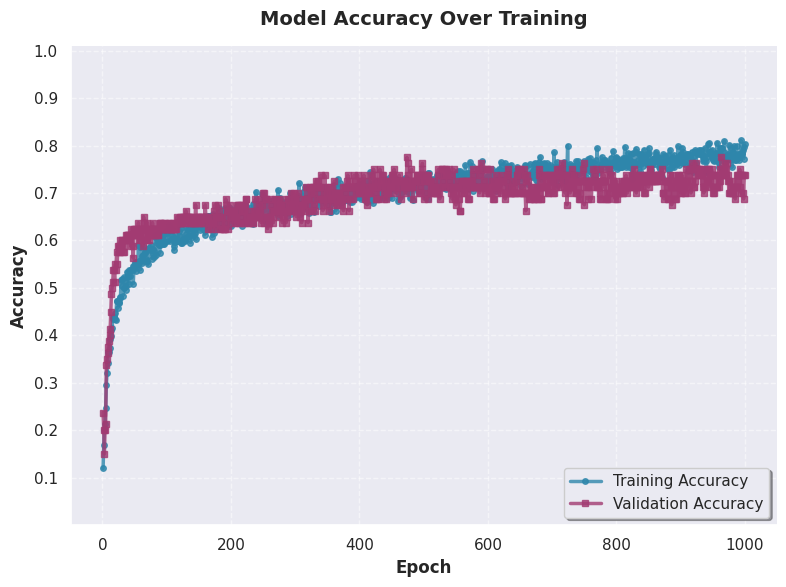

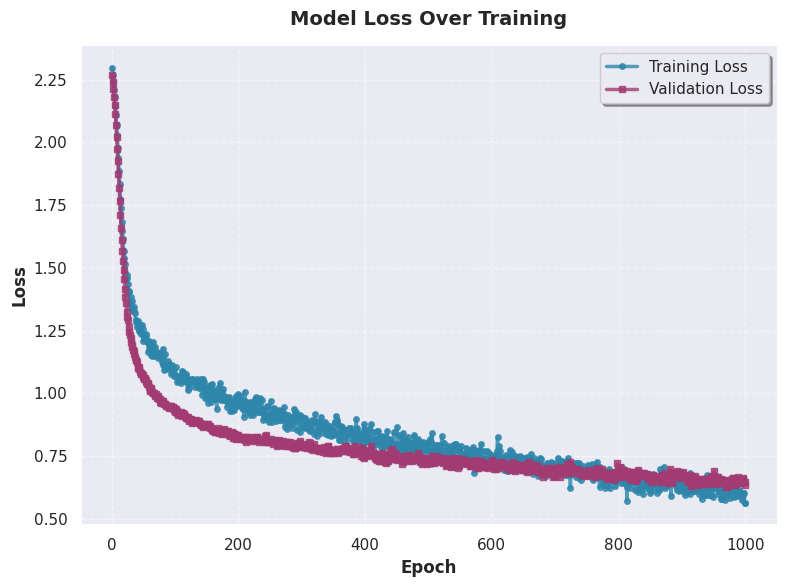

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


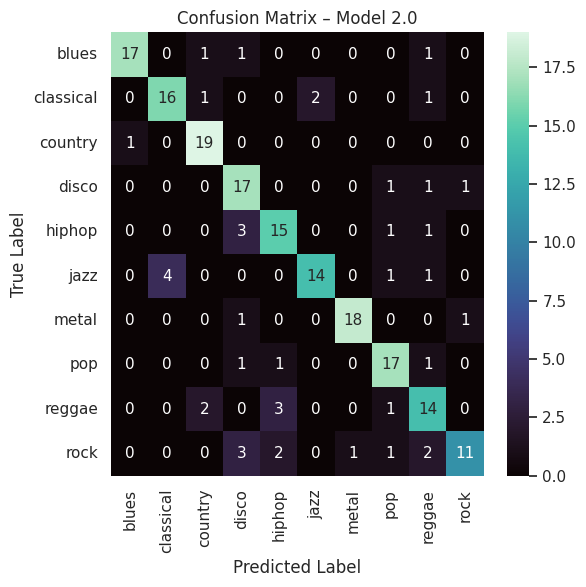

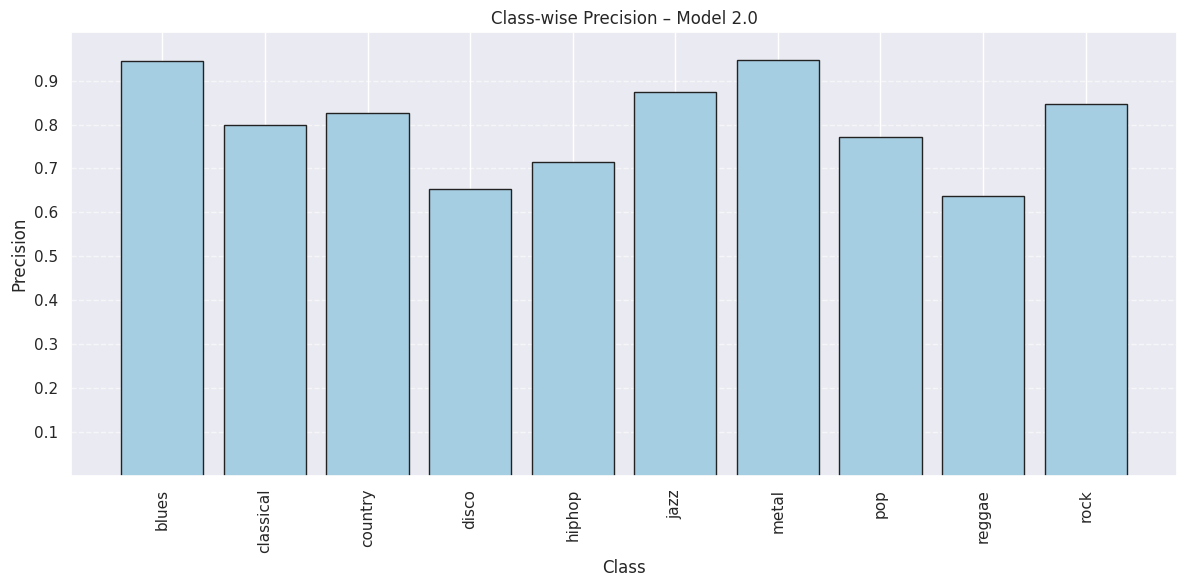

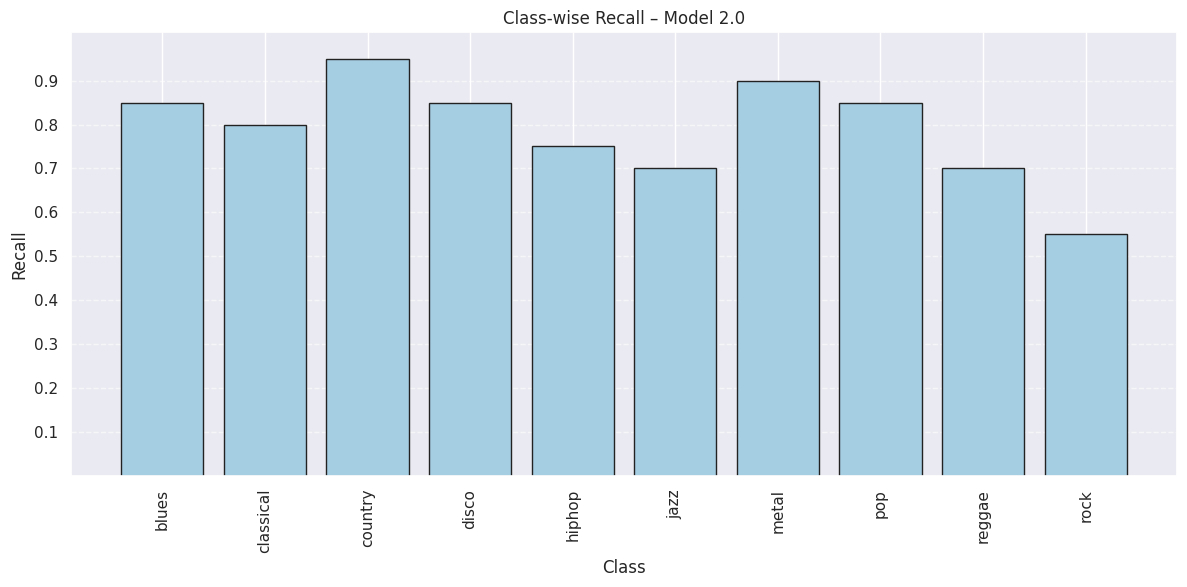

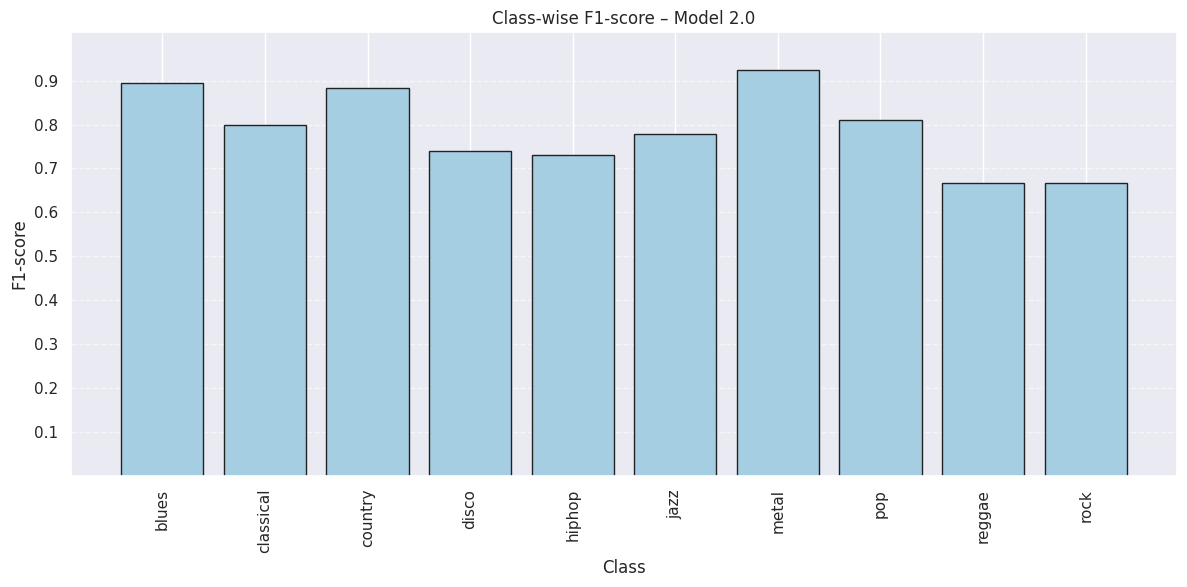

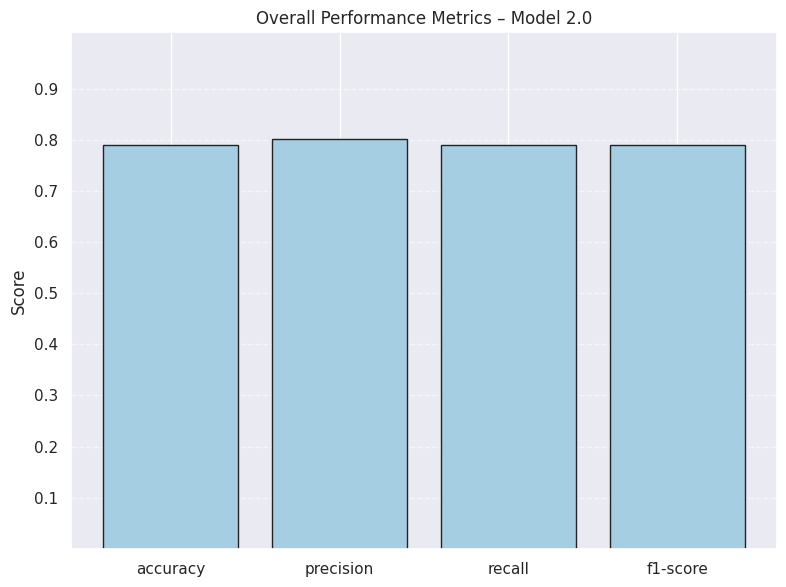

0.79


In [9]:
model_version = "2.0"
model_HCNN = Sequential([
    Input(shape=(CSV_FEATURES_NUMBER + CONV_FEATURES_NUMBER, )),
    Dropout(0.1),
    Dense(128, activation="gelu"),
    Dropout(0.1),
    Dense(64, activation="relu"),
    Dense(NUM_CLASSES, activation = "softmax")
], name = model_version)

model_HCNN.summary()
    
model_HCNN.compile(
   metrics = ["accuracy"],
   loss = "categorical_crossentropy",
   optimizer = Adam(learning_rate=1e-3)
)

history = model_HCNN.fit(
   X_train_HCNN, y_train_HCNN,
   batch_size = 256,
   epochs = 1000,
   validation_data = (X_val_HCNN, y_val_HCNN),
   callbacks = [EarlyStopping(patience=200, monitor="val_loss", restore_best_weights=True)]
)

plot_accuracy(history)
plot_loss(history)

y_pred_HCNN = model_HCNN.predict(X_test_HCNN)
y_pred_HCNN_int = np.argmax(y_pred_HCNN, axis = 1)
y_test_HCNN_int = np.argmax(y_test_HCNN, axis = 1)
plot_confusion_matrix(y_test_HCNN_int, y_pred_HCNN_int, model_HCNN.name)

accuracy, precision, recall, f1_score = create_report(y_test_HCNN, y_pred_HCNN, model_version)
plot_overall_metrics({
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1-score': f1_score 
}, model_version)
print(accuracy)

In [10]:
print({'2.1': {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1-score': f1_score 
}})

{'2.1': {'accuracy': 0.79, 'precision': 0.8016276445395439, 'recall': 0.79, 'f1-score': 0.7893007367905446}}


## Model 3.1 & 3.2 & 3.3
Ensemble of Model 2.0, and Model 1.2 RNN

In [11]:
NUM_TIMESTEPS = 10

# Read RNN data
data = pd.read_csv(BASE_PATH + "features_3_sec.csv")
data.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [12]:
# Remove the rows corresponding to the missing image
jazz_to_remove = [f"jazz.00054.{i}.wav" for i in range(10)]
data = data[~data["filename"].isin(jazz_to_remove)]

# Create the X_filename_RNN dataset
X_RNN = data.drop(columns=["length", "label"])
X_filename_RNN = X_RNN['filename'].to_numpy()

# Get the RNN features 
X_features_RNN = X_RNN.drop(columns=["filename"]).to_numpy()
NUM_RNN_FEATURES = len(X_features_RNN[0])

In [13]:
# The original dataset contains 10 rows per instance, each corresponding to a timestep;
# here we aggregate them into a 3D tensor of shape (999 instances × 10 timesteps × 57 features)
# to be used as input for the RNN.

# Allocate the needed memory
X_RNN = np.zeros((999, NUM_TIMESTEPS, NUM_RNN_FEATURES))
y_RNN = np.zeros((999))

instance_index = -1
skip_offset = 0
prev_timestep = 10

for name in X_filename_RNN:
    split_name = name.split(".")
    
    # Get the genre and timestamp of the current instance
    cur_genre = split_name[0]
    cur_timestep = int(split_name[2])
    
    if cur_timestep == 0: # New instance
        
        # If the number of timesteps of the previous instance is less than 10
        if prev_timestep == 8:
            skip_offset += 1
            
            # Infer the last timestep by using the mean of the previous ones
            X_RNN[instance_index, 9,:] = np.mean(X_RNN[instance_index, 0:9, :], axis = 0)
        instance_index += 1

    # Update the timestep
    prev_timestep = cur_timestep

    X_RNN[instance_index, cur_timestep, :] = X_features_RNN[instance_index * 10 + cur_timestep - skip_offset, :]
    y_RNN[instance_index] = GENRES.index(cur_genre)

In [14]:
def get_X_RNN(indices_path, X_RNN):

    # Read indices
    with open(indices_path, "r") as file:
        indices = json.load(file)

    # Allocate needed memory
    X_ret = np.zeros((len(indices), NUM_TIMESTEPS, NUM_RNN_FEATURES))
    
    i = 0
    for index, _ in indices:
        X_ret[i] = X_RNN[index]
        i = i + 1
    
    return X_ret

In [15]:
X_train_RNN = get_X_RNN(BASE_PATH + "indices_train.json", X_RNN)
X_test_RNN = get_X_RNN(BASE_PATH + "indices_test.json", X_RNN)
X_val_RNN = get_X_RNN(BASE_PATH + "indices_val.json", X_RNN)

In [16]:
num_instances_test = X_test_RNN.shape[0]

# Flatten the train and test datasets
X_train_flat_RNN = X_train_RNN.reshape(-1, NUM_RNN_FEATURES)
X_test_flat_RNN = X_test_RNN.reshape(-1, NUM_RNN_FEATURES)

# Scale the data
scaler = preprocessing.MinMaxScaler()
X_train_scaled_RNN = scaler.fit_transform(X_train_flat_RNN)
X_test_scaled_RNN = scaler.transform(X_test_flat_RNN)

# Reshape back
X_test_RNN = X_test_scaled_RNN.reshape(num_instances_test, NUM_TIMESTEPS, NUM_RNN_FEATURES)

In [17]:
# Load RNN model
model_RNN = keras.models.load_model(BASE_PATH + "RNN.keras")

ensemble_preds_model_1 = np.zeros(len(X_test_RNN))
ensemble_preds_model_2 = np.zeros(len(X_test_RNN))
ensemble_preds_model_3 = np.zeros(len(X_test_RNN))
i = 0
for X_test_instance_NN, X_test_instance_RNN in zip(X_test_HCNN, X_test_RNN):

    # Use the previously defined models to predict
    pred_NN = model_HCNN.predict(np.expand_dims(X_test_instance_NN, axis=0), verbose = 0)[0]
    pred_RNN = model_RNN.predict(np.expand_dims(X_test_instance_RNN, axis=0), verbose = 0)[0]
    
    # Ensemble Model 1
    # Sum the probabilities distributions
    sum_preds = pred_NN + pred_RNN
    
    # Select the most likely class as the predicted one
    pred = np.argmax(sum_preds, axis = -1)
    ensemble_preds_model_1[i] = int(pred)

    # Ensemble Model 2
    # Get the most likely class for each model
    pred_NN_test = int(np.argmax(pred_NN, axis = -1))
    pred_RNN_test = int(np.argmax(pred_RNN, axis = -1))
    
    # If they both predicted the same class
    if pred_NN_test == pred_RNN_test:
        ensemble_preds_model_2[i] = pred_NN_test
    else:
        # If they disagree, choose the class with the highest probability
        if pred_NN[pred_NN_test] > pred_RNN[pred_RNN_test]:
            ensemble_preds_model_2[i] = pred_NN_test
        else:
            ensemble_preds_model_2[i] = pred_RNN_test

    # Ensemble Model 3
    sum_preds = pred_NN * pred_RNN
    
    # Select the most likely class as the predicted one
    pred = np.argmax(sum_preds, axis = -1)
    ensemble_preds_model_3[i] = int(pred)
    
    i = i + 1

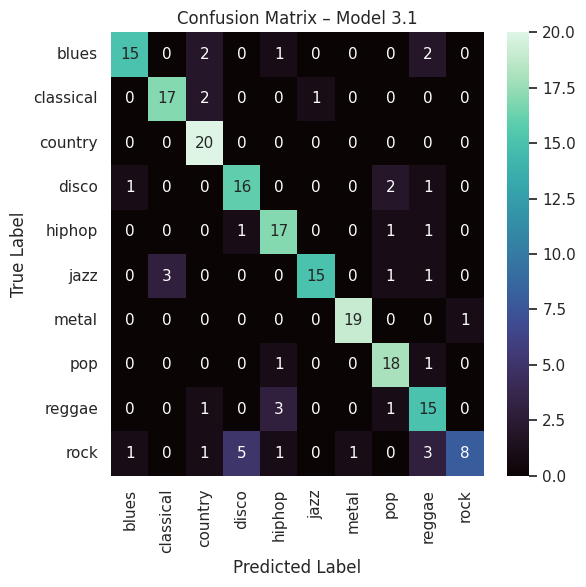

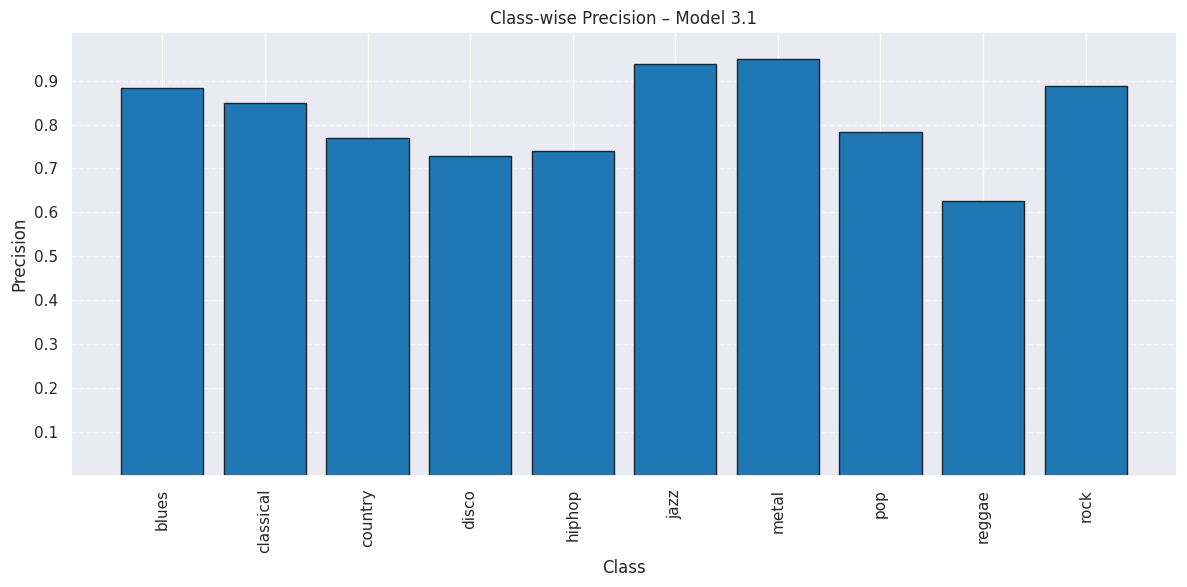

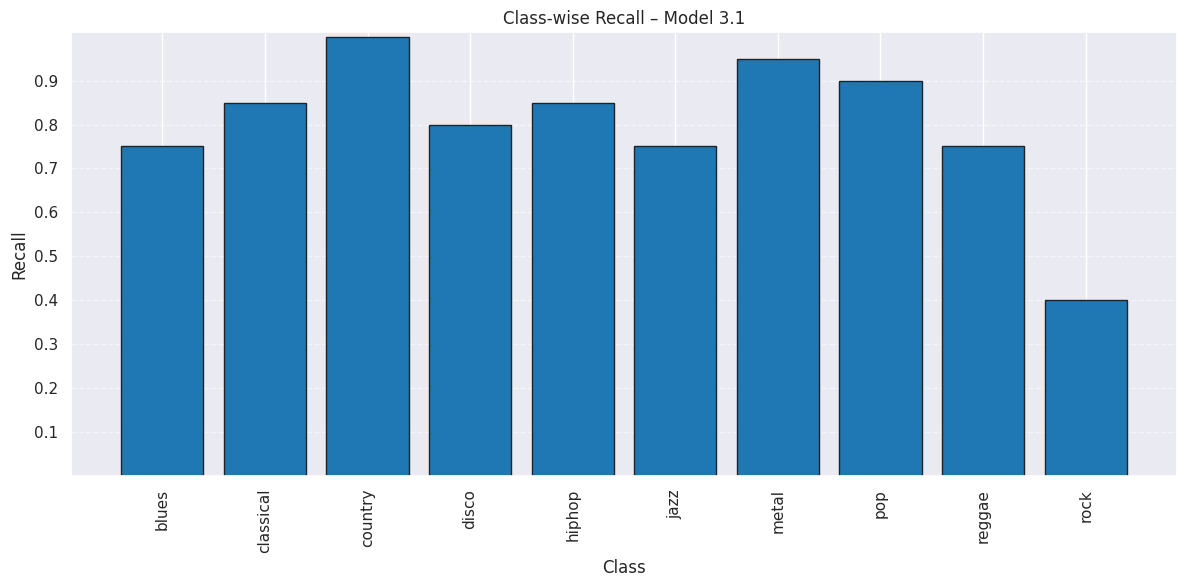

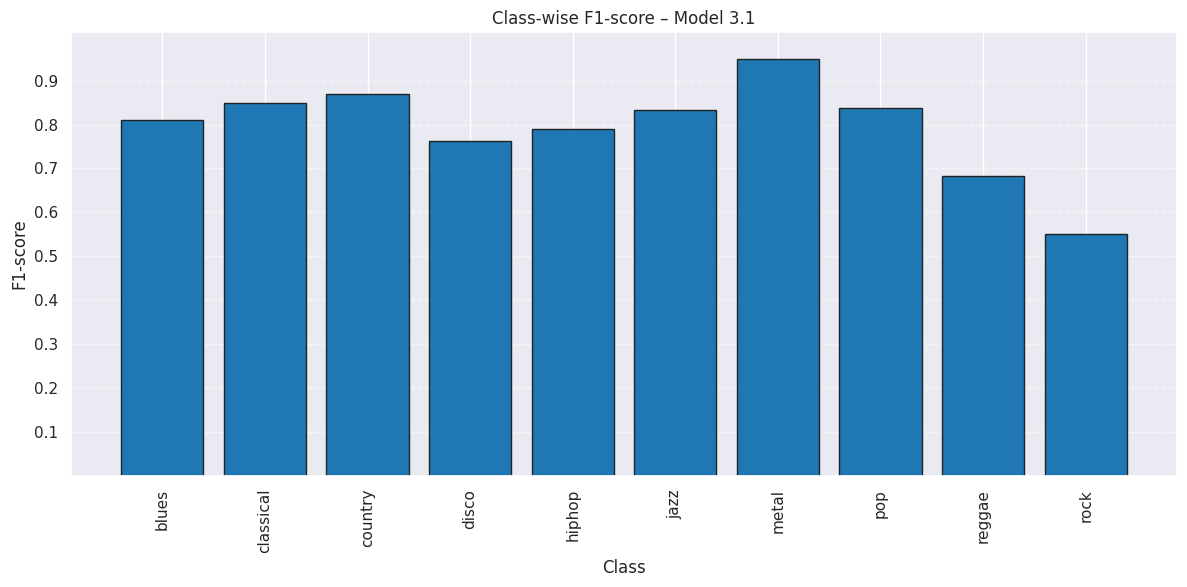

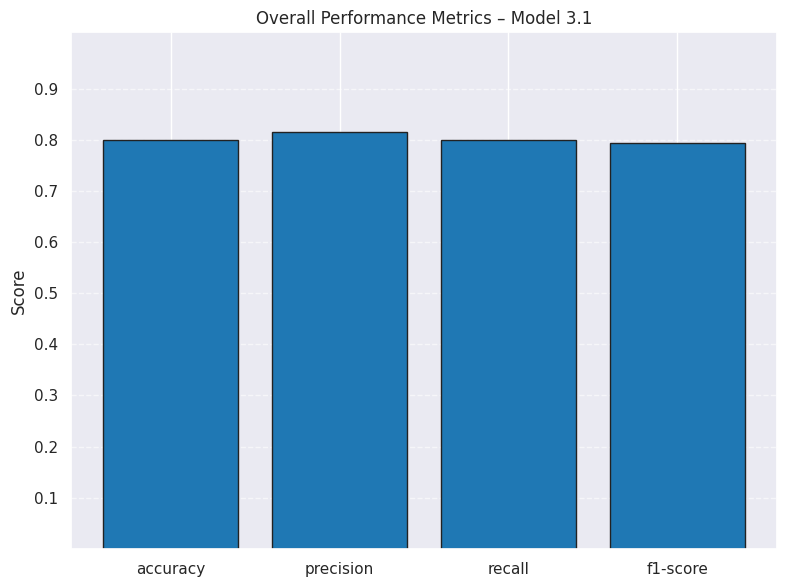

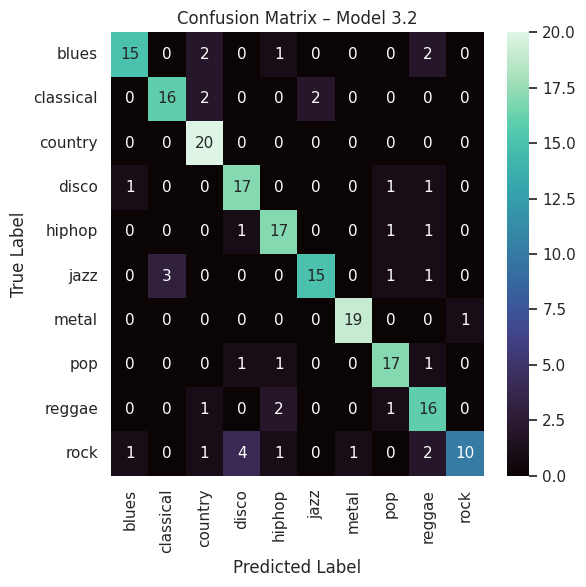

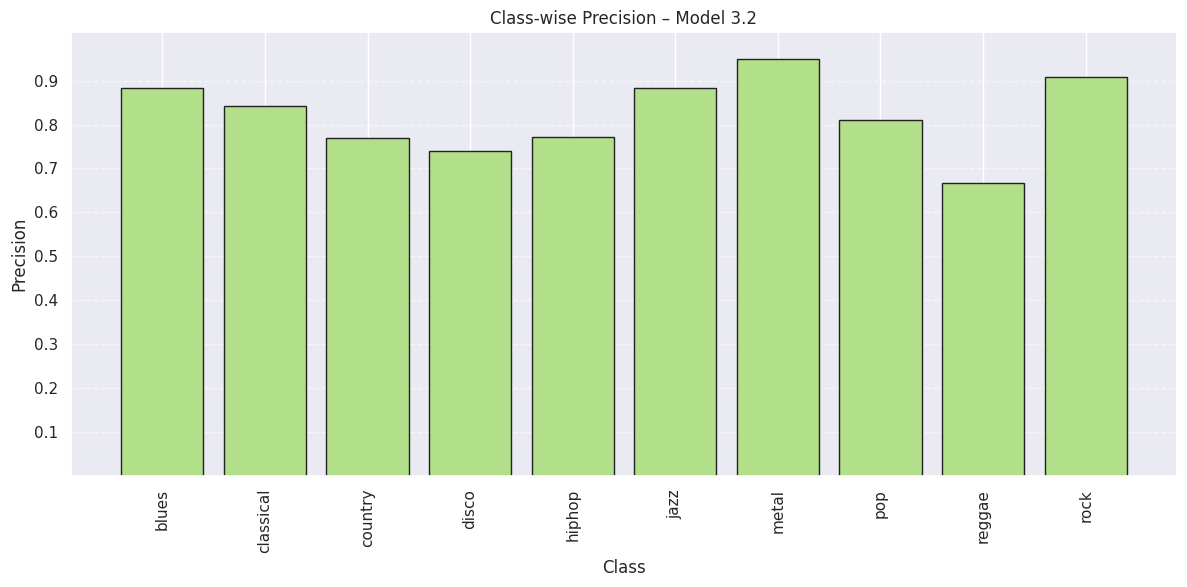

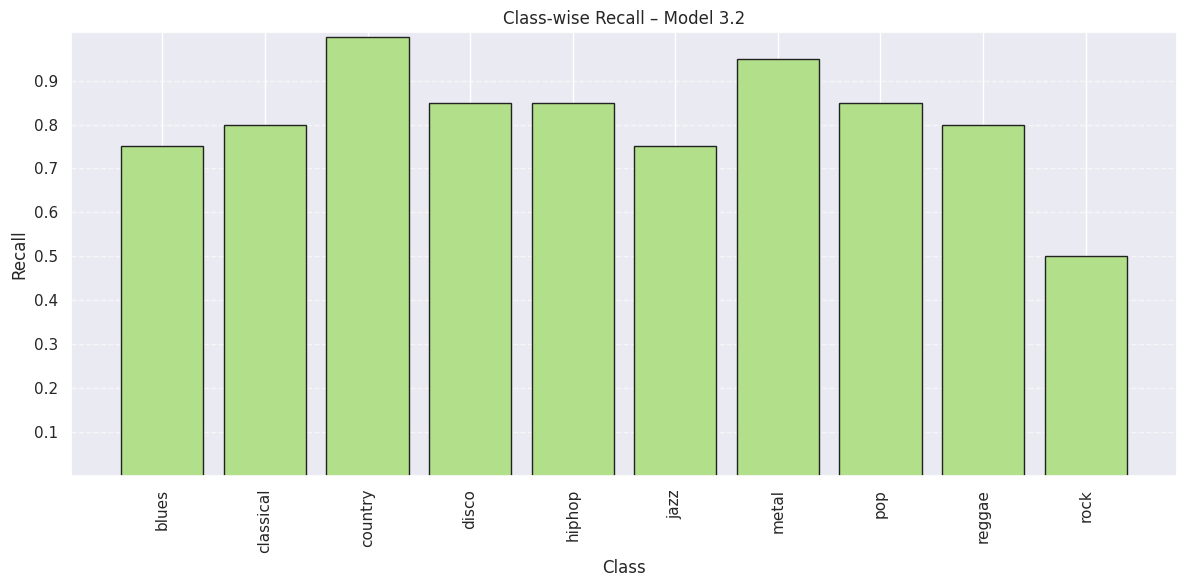

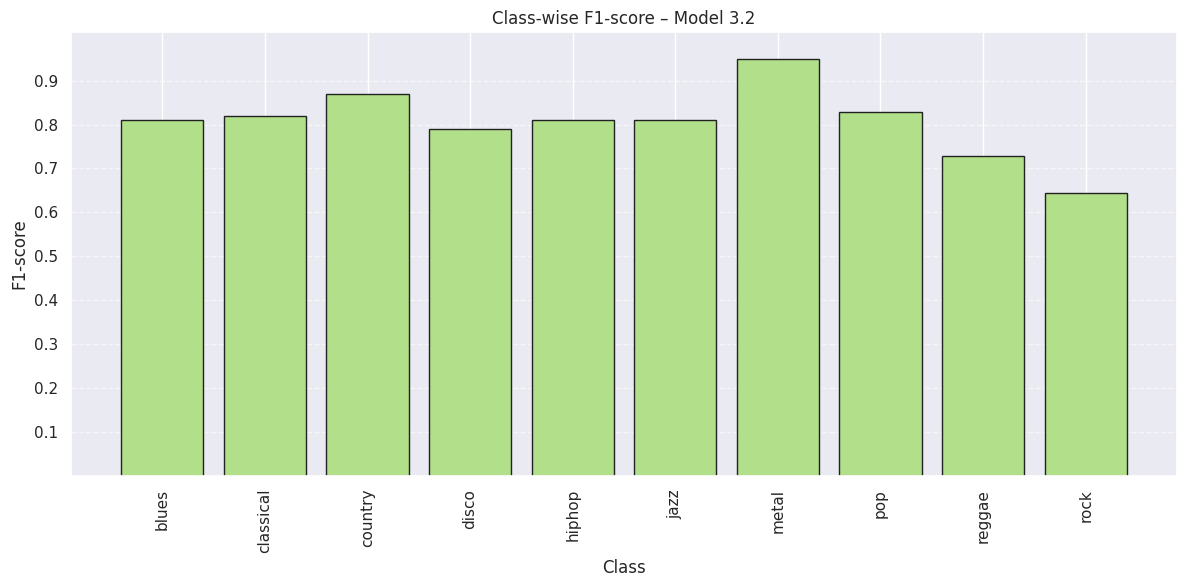

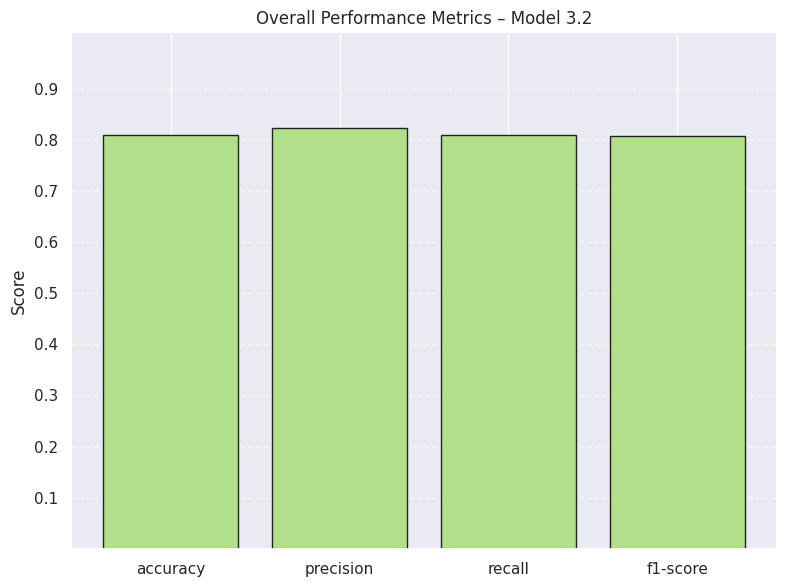

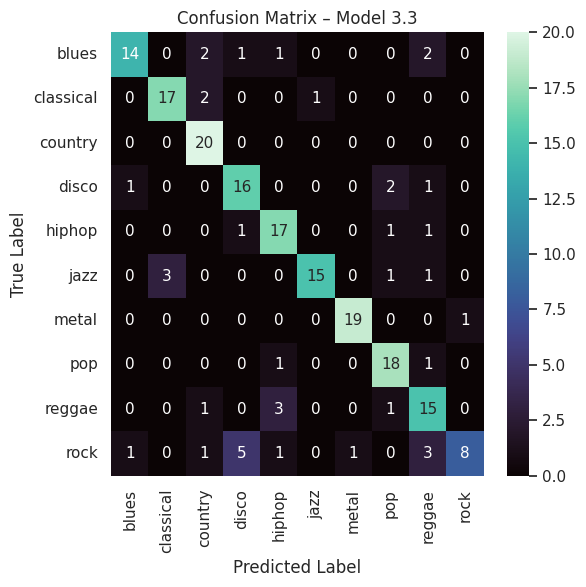

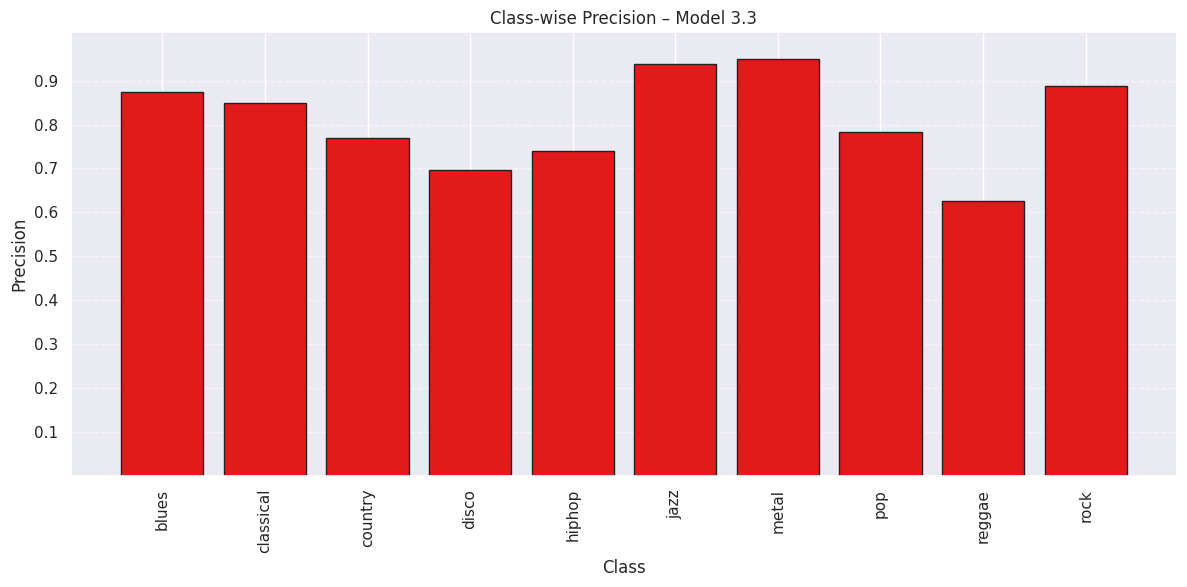

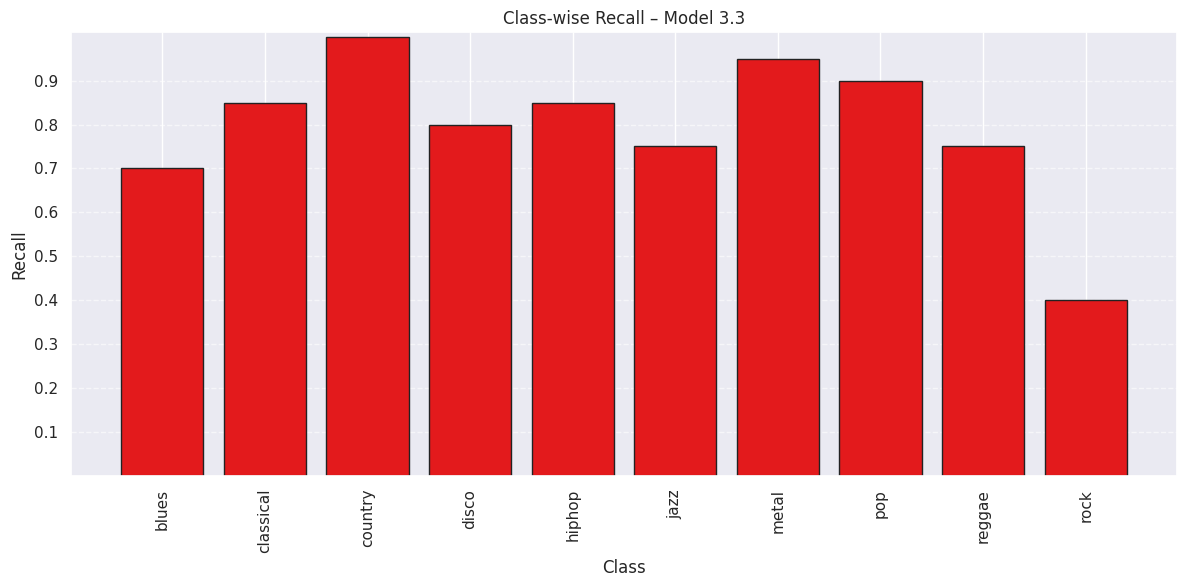

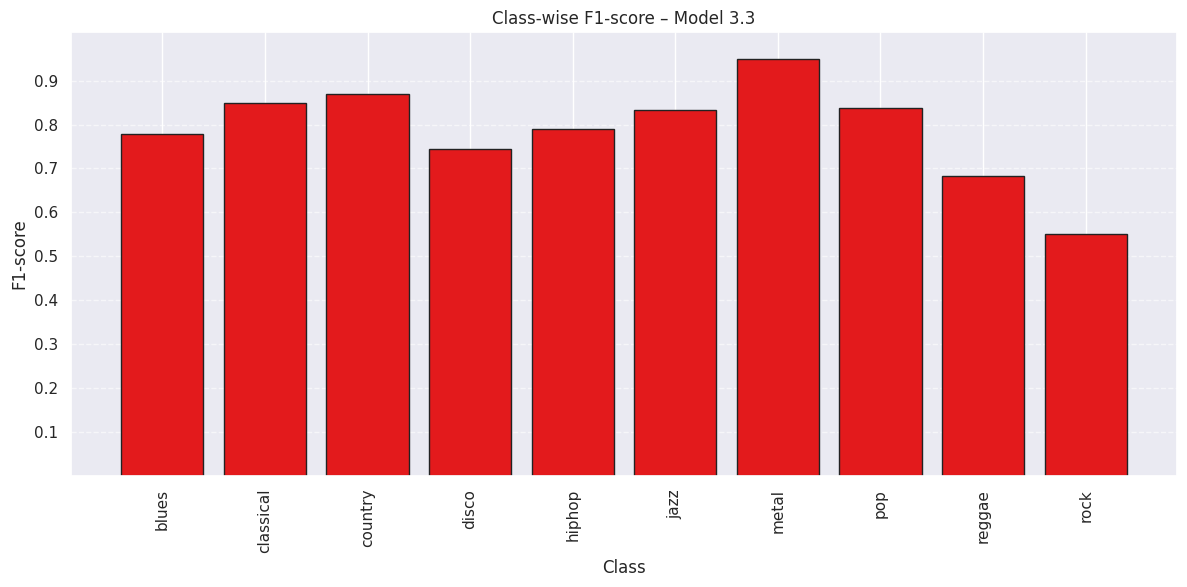

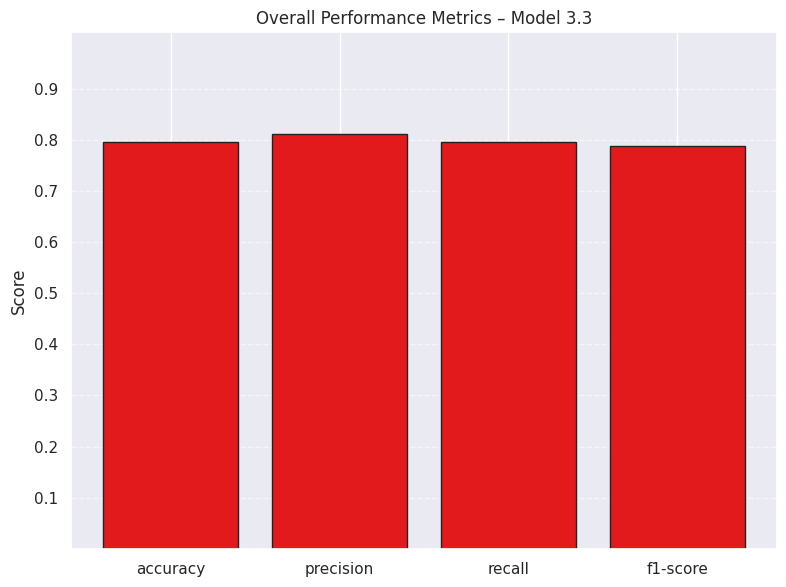

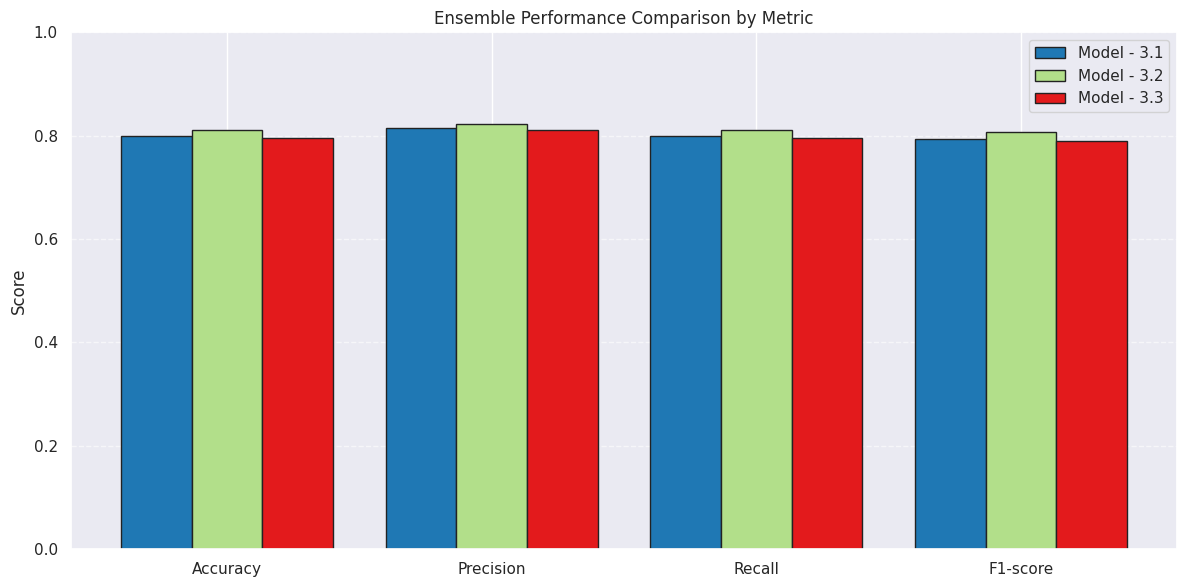

{'3.1': {'accuracy': 0.8, 'precision': 0.8151984457003639, 'recall': 0.8, 'f1-score': 0.7937063419933612}, '3.2': {'accuracy': 0.81, 'precision': 0.8223181007532873, 'recall': 0.8100000000000002, 'f1-score': 0.8063623453746395}, '3.3': {'accuracy': 0.795, 'precision': 0.8113010962467484, 'recall': 0.795, 'f1-score': 0.7886311671507445}}


In [18]:
performances = {}

# Evaluate the single models
performances = evaluate_ensemble(y_test_HCNN, to_categorical(ensemble_preds_model_1), "3.1", performances)
performances = evaluate_ensemble(y_test_HCNN, to_categorical(ensemble_preds_model_2), "3.2", performances)
performances = evaluate_ensemble(y_test_HCNN, to_categorical(ensemble_preds_model_3), "3.3", performances)

# Compare the ensemble models
plot_metrics_comparison(performances)

print(performances)